In [1]:
from dreimac import CircularCoords

from circle_bundles.viz.pca_viz import show_pca
from circle_bundles.viz.thumb_grids import *
from circle_bundles.viz.fiber_vis import *
from circle_bundles.viz.nerve_vis import *
from circle_bundles.viz.base_vis import *
from circle_bundles.viz.lattice_vis import *
from circle_bundles.viz.circle_vis import *
from circle_bundles.bundle import build_bundle, attach_bundle_viz_methods
from circle_bundles.covers import MetricBallCover
from circle_bundles.metrics import RP1_dist2, get_dist_mat
from circle_bundles.local_triv import *
attach_bundle_viz_methods()


from synthetic.nat_img_patches import *
from optical_flow.patch_viz import *


#For saving
folder_path = '/Users/bradturow/Desktop/Diagrams/Paper Diagrams/'

# Klein Bottle Model

In [2]:
#Generate a sampling of the Klein bottle model over RP1
n_samples = 5000
n = 3

data, base_points = sample_nat_img_kb(n_samples, n = n)
grad_dirs = get_gradient_dirs(data)
print(f'{n_samples} natural image patches generated.')

5000 natural image patches generated.


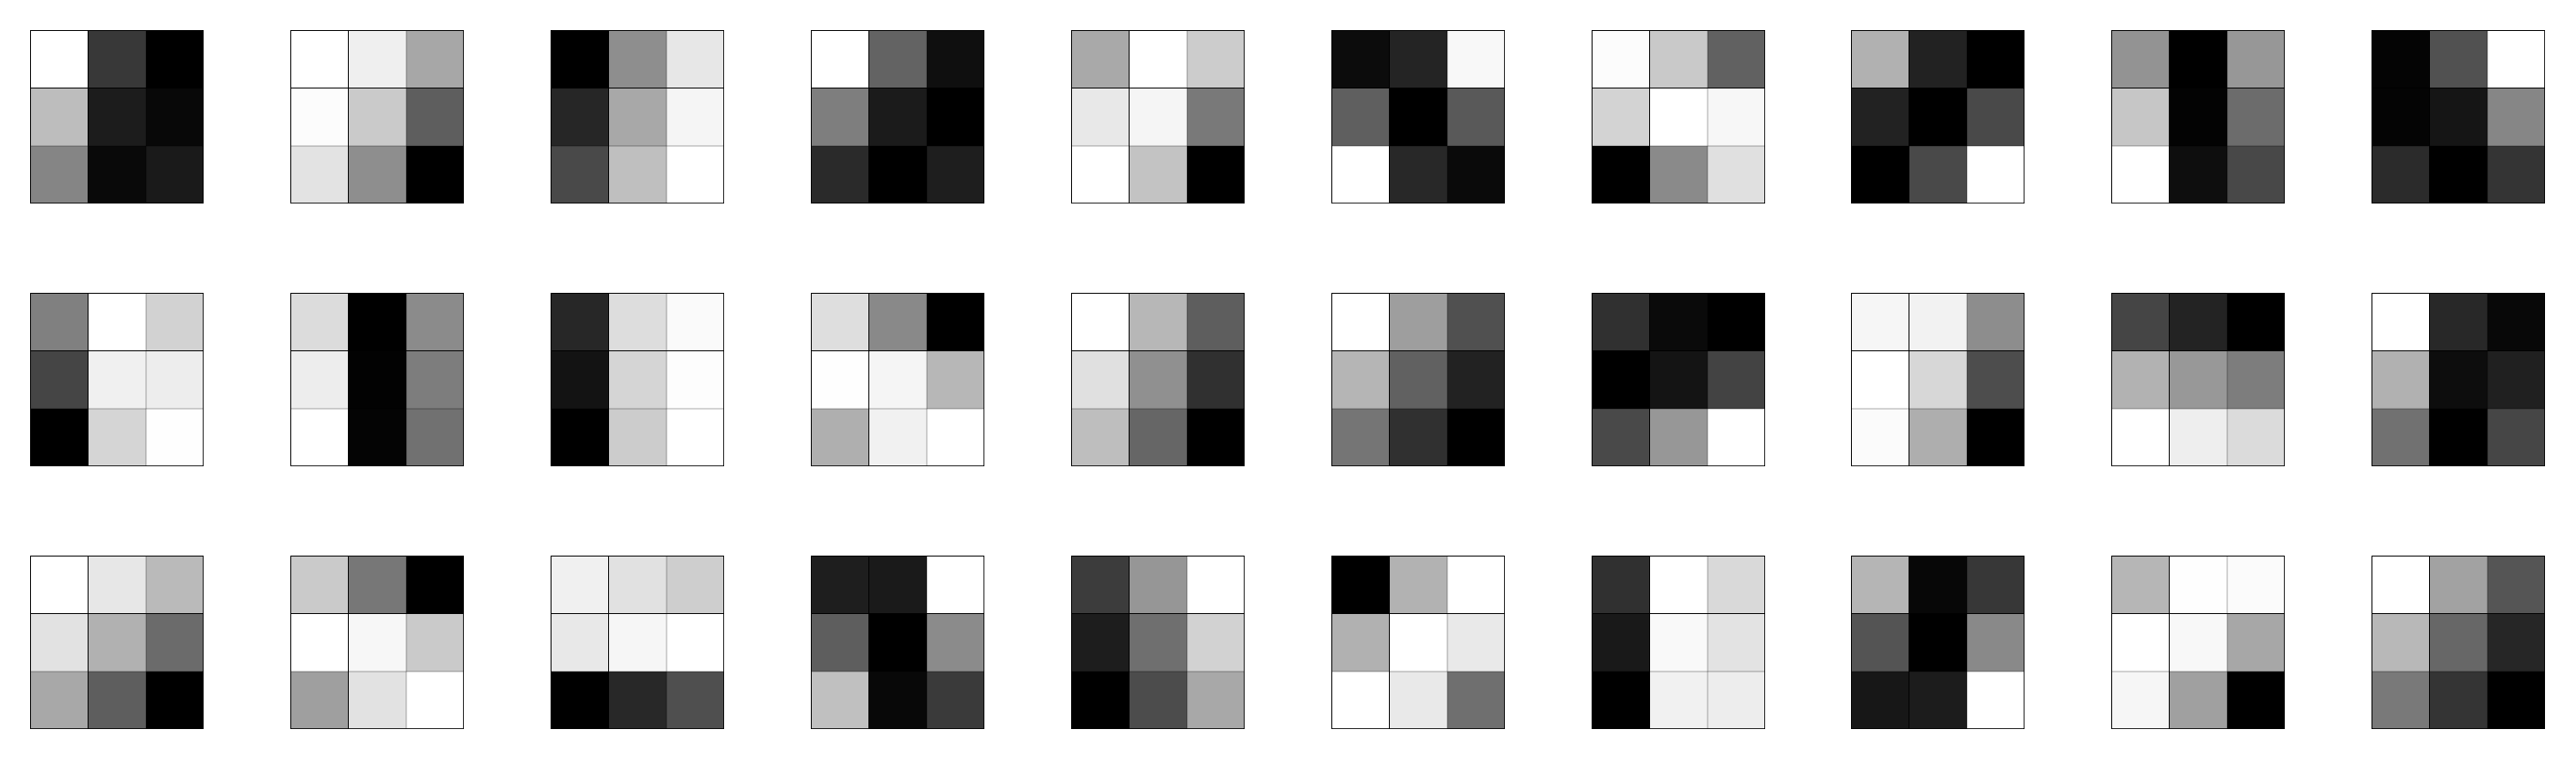

In [3]:
#View a sample of the data
patch_vis = make_patch_visualizer()
fig = show_data_vis(data, patch_vis, sampling_method = None, max_samples = 30)
plt.show()

In [ ]:
#Show a PCA visualization of the dataset
show_pca(data)

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

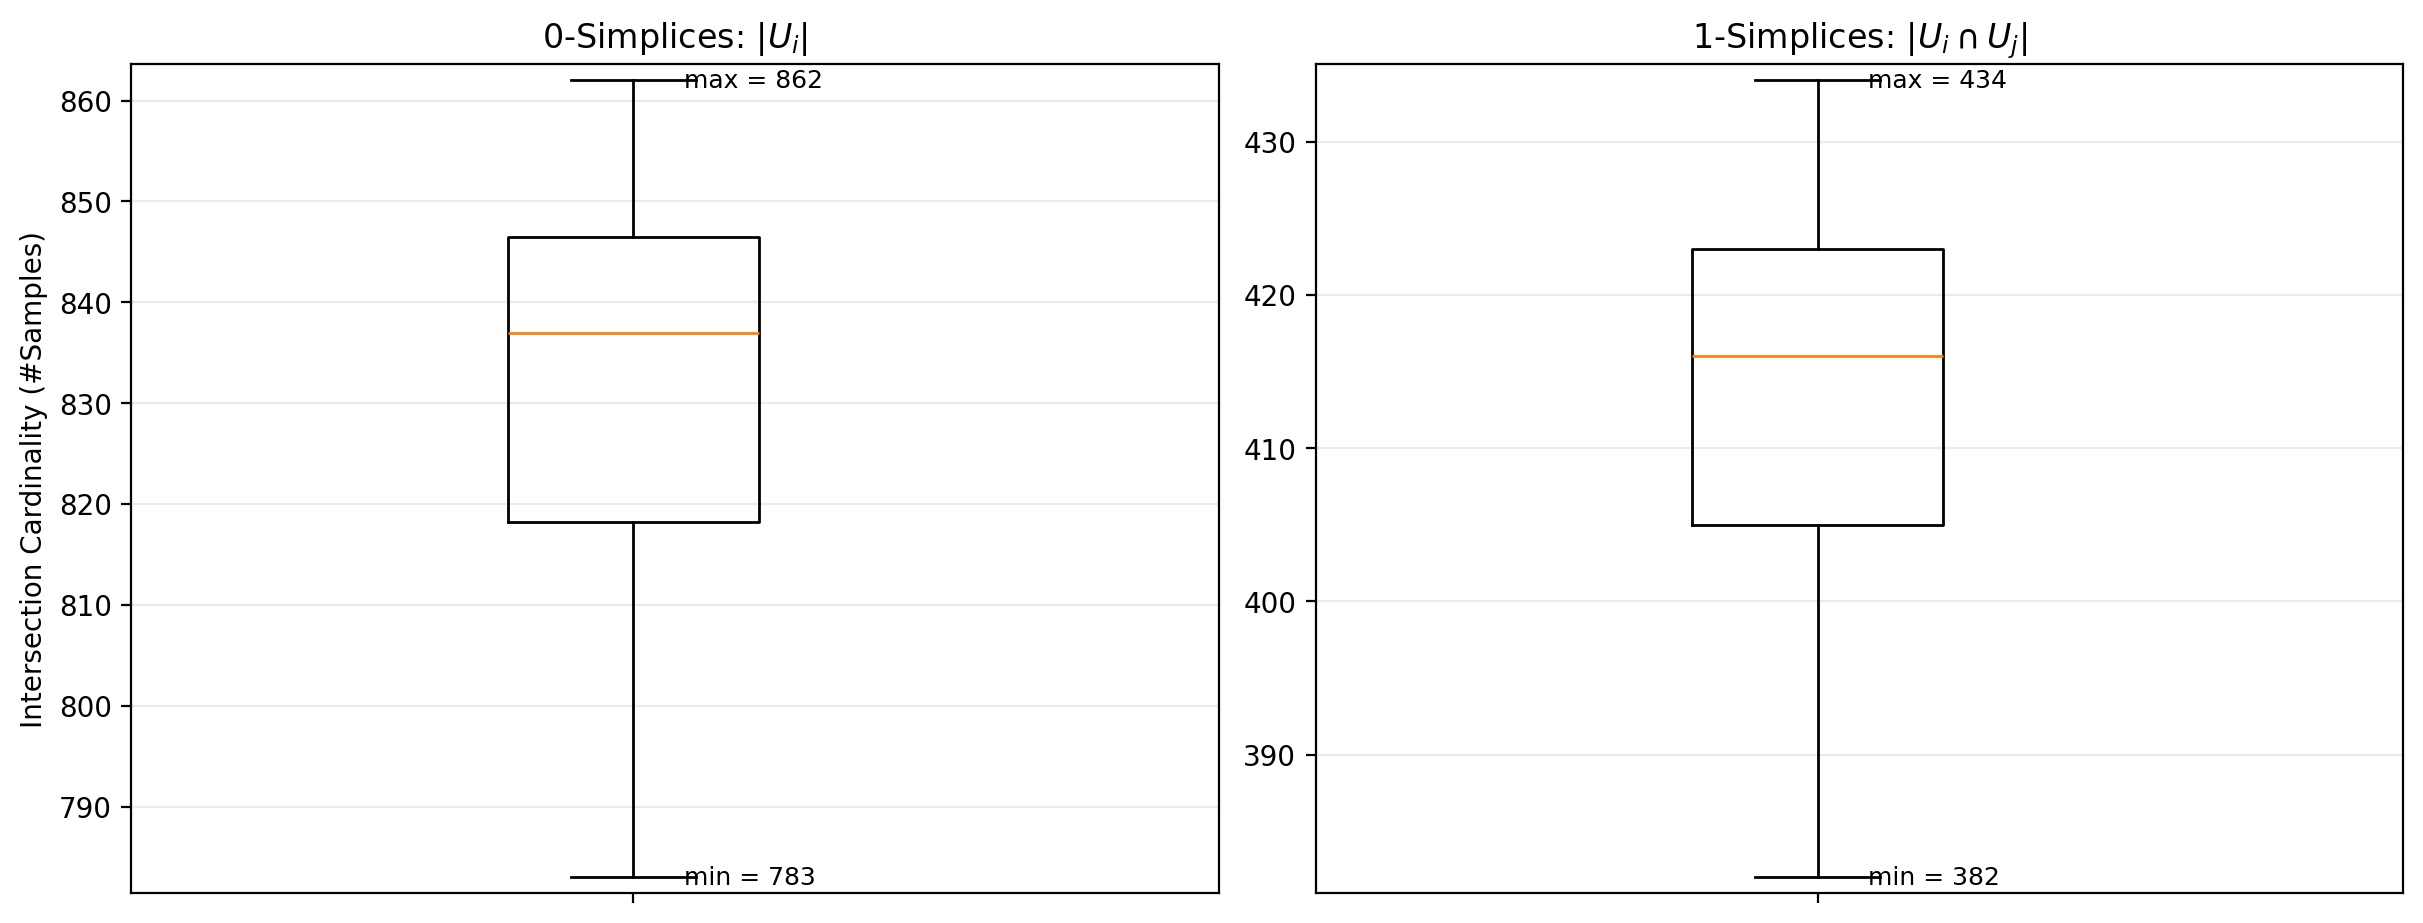

In [4]:
#Construct a cover of the base space
n_landmarks = 12
lmk_angs = np.linspace(0, np.pi,n_landmarks, endpoint= False)
landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
overlap = 1.99

radius = overlap* np.pi/(2*n_landmarks)

cover = MetricBallCover(base_points, landmarks, radius, metric = RP1_dist2)
cover_data = cover.build()

#Show a summary of the cover
summ = cover.summarize(plot=True)
plt.show()

In [5]:
#Construct local circular coordinates and model transitions as O(2) matrices
bundle = build_bundle(
    data,
    cover,
    CircularCoords_cls=CircularCoords,
    show=True,
)


<IPython.core.display.Math object>

In [6]:
from circle_bundles.bundle_map import *
U = cover.U
pou = cover.pou
f = bundle.local_triv.f
Omega = bundle.classes.cocycle_used.Omega


In [7]:
from circle_bundles.frame_reduction import *

# 2) choose a dimension grid
D = tf.Phi_true.shape[2]
dims = list(range(2, min(D, 60) + 1, 2))  # e.g. 2,4,6,...,60

# 3) run PSC curve (subsample frames if you want speed)
dims_arr, psc_err = reduction_curve_psc(
    Phi_true=tf.Phi_true,
    U=U,
    dims=dims,
    max_frames=2000,     # adjust; None uses all (might be huge)
    rng_seed=0,
    psc_verbosity=0,
    use_manopt=False,    # set False to use PSC_PCA only (faster)
)

# 4) (optional) compare against your baseline curve
dims_arr2, pca_err = reduction_curve_subspace_pca(
    Phi_true=tf.Phi_true,
    U=U,
    dims=dims,
    max_frames=2000,
    rng_seed=0,
)
plt.show()

NameError: name 'tf' is not defined

In [12]:
from circle_bundles.bundle_map import *
import sys
sys.path.append('/Users/bradturow/PSC')

reducer = FrameReducerConfig(method="subspace_pca", d=4, max_frames=5000, psc_verbosity=1)


F, pre_F, Omega_used, Phi_used, report= get_bundle_map(
    U = U,
    pou = pou,
    f = f,
    Omega = Omega,
    reducer = reducer,
    show_summary = True
)



### Coordinatization

**Cocycle projection distance**  
$d_{\infty}(\Omega,\Pi(\Omega))=\sup_{(jk)}\sup_{b\in\pi(X)\cap(U_j\cap U_k)}\ \|\Omega_{jk}(b)-\Pi(\Omega)_{jk}(b)\|_{F}$

- $\approx 0.000$

**Witness quality**  
$\sup_{(jk)}\sup_{x:\ \pi(x)\in U_j\cap U_k}\ d_{\mathbb{S}^{1}}\!\left(f_j(x),\ \Omega_{jk}(\pi(x))f_k(x)\right)$

- $\approx 0.335$ (rad)

**Auxiliary diagnostics**

- Grassmann projection distance $\approx 0.000$
- Stiefel projection distance $\approx 0.000$

**Chart disagreement (max)**  
$\max_{s}\ \Delta(s),\quad \Delta(s)=\max_{j,j'\in J_s}\|F_j(s)-F_{j'}(s)\|_2$

- $\approx 0.000$

**Frame reduction** (`subspace_pca`, $d=4$)

- Mean projection error $\mathbb{E}\,\|Y - BB^{\mathsf{T}}Y\|_{F}$ $\approx 1.185$


In [13]:
from circle_bundles.viz.bundle_dash import *
#help(show_bundle_vis)
app = show_bundle_vis(base_points = base_points, data  = F, base_metric = RP1_dist2)
plt.show()

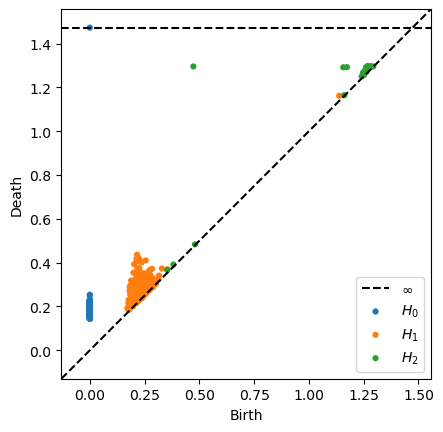

In [14]:
#Run Ripser on the dataset
from ripser import ripser
from persim import plot_diagrams
prime = 2
diagrams = ripser(F, coeff = prime, maxdim = 2, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    

In [ ]:

N, n = F.shape
k = 1
s = 1  # number of noisy samples per point

# Generate ys as a list of (n, k) matrices
ys_list = []

for i in range(s):
    ys_list.append(F.T + 0.01*np.random.randn(n, N))  # shape (n, N)
    
# Stack into array of shape (n, N, s)
ys = np.stack(ys_list, axis=2)  # shape (n, N, s)
print("ys.shape:", ys.shape)  


alpha_random = random_point(N, n)
print("Projection cost (random alpha):", projection_cost(alpha_random, ys))
print("Nuclear norm cost (random alpha):", nuc_cost(alpha_random, ys))

alpha_PCA = PCA(ys, n)
alpha_GD = manopt_alpha(ys, alpha_PCA, verbosity=1)

print("alpha_GD.shape:", alpha_GD.shape)  # (5000, 12)
print("Projection cost (GD alpha):", projection_cost(alpha_GD, ys))


In [ ]:
#Run Ripser on the dataset
from ripser import ripser
from persim import plot_diagrams
prime = 2
diagrams = ripser(data, coeff = prime, maxdim = 2, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    

In [ ]:
#Compute class persistence on the weights filtration of the nerve
pers = bundle.get_persistence(show = True)


In [ ]:
#Get a global coordinatization compatible with the maximal subcomplex of the nerve on which 
#the characteristic class representatives are coboundaries 

triv_result = bundle.get_global_trivialization()
print('Global coordinates computed.')

In [ ]:
#Show an interactive visualization of the bundle colored by fiber coordinate
fig = bundle.show_bundle(get_dist_mat = get_dist_mat, colors = triv_result.F)
plt.show()

In [ ]:
#Show the correlations between local circular coordinates on overlaps
fig = bundle.compare_trivs(ncols = 4)
plt.show()

In [ ]:
#Show a visualization of the nerve labeled with SW1

#Compute a potential for the restricted orientation class
subcomplex = bundle.get_max_trivial_subcomplex()
edges = subcomplex.kept_edges
Omega = bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = bundle.classes.omega_O1_used

fig = bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()

In [ ]:
#Show a recovered patch diagram
per_row = 5
per_col = 9
predom_dirs = np.arctan2(base_points[:,1], base_points[:,0]) % np.pi
coords = np.column_stack([predom_dirs.reshape(-1,1), triv_result.F.reshape(-1,1)])

fig = lattice_vis(
    data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=15,
    thumb_px=350,   
    dpi=350         
)

plt.show()
